# Data Preprocessing

## Import Data and Overview

In [47]:
import pandas as pd

full_data = pd.read_csv('data.csv')

In [48]:
full_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [49]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Data Cleaning

### Drop<br>Dummy columns:<br> ['name', 'email', 'phone-number', 'credit_card']<br>Redundant columns:<br>['is_canceled', 'arrival_date_week_number']<br>Irrelevant Columns:<br>['reservation_status_date']

In [50]:
clean_data = full_data.drop(['name', 'email', 'phone-number', 'credit_card', 'is_canceled', 'arrival_date_week_number', 'reservation_status_date'], axis=1)

### Check for NaN values

In [51]:
clean_data.isna().sum()

hotel                                  0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type   

### Fill in missing values with probable/appropriate values

In [52]:
clean_data['children'].fillna(value=0, inplace=True)
clean_data['country'].fillna(value='COUNTRY_UNKNOWN', inplace=True)
clean_data['agent'].fillna(value=0, inplace=True)
clean_data['company'].fillna(value=0, inplace=True)

## Data Transformation

### Sample Data

In [53]:
data = clean_data.sample(n=10000)
data.index = range(len(data))

### Convert month name to month number

In [54]:
month_map = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12,}
data.arrival_date_month = data.arrival_date_month.map(month_map)

### Convert other categorical variables into numeric variables and map it using a dataframe

In [55]:
cat_list = [column for column in data.columns if data[column].dtype == 'object']
cat_map = pd.DataFrame(columns=['variable', 'old_val', 'new_val'])

for cat in cat_list:
    cat_val = pd.Series(data[cat].unique())
    for _val in range(len(cat_val)):
        cat_dict = pd.Series({'variable' : cat, 'old_val' : cat_val[_val], 'new_val' : _val})
        cat_map = pd.concat([cat_map, cat_dict.to_frame().T], ignore_index=True)
        data[cat] = data[cat].replace(cat_val[_val], _val)
cat_map.set_index(['variable', 'old_val'], inplace=True)
cat_map.loc["hotel"]        

,new_val
old_val,
Resort Hotel,0
City Hotel,1


### Print Processed DataFrame

In [56]:
data.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
0,0,13,2016,3,9,0,3,2,0.0,0,...,1,0,115.0,0.0,0,0,86.55,0,0,0
1,0,108,2016,3,1,0,1,2,0.0,0,...,0,0,240.0,0.0,0,1,46.40,0,2,1
2,1,198,2016,5,20,0,1,2,0.0,0,...,0,0,1.0,0.0,98,0,65.00,0,0,0
3,1,274,2017,8,14,1,1,2,0.0,0,...,0,0,9.0,0.0,0,1,89.10,0,1,0
4,1,0,2017,2,25,1,1,2,1.0,0,...,0,0,9.0,0.0,0,1,142.00,0,1,0


## Scale Predictor Variables

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X = data.drop(['reservation_status'], axis=1)
Y = data['reservation_status']

SS = StandardScaler()
X_std = SS.fit_transform(X)

MMS = MinMaxScaler()
X_mm = MMS.fit_transform(X)

# Data Visualization

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

## reservation_status(target variable) - Pie Chart

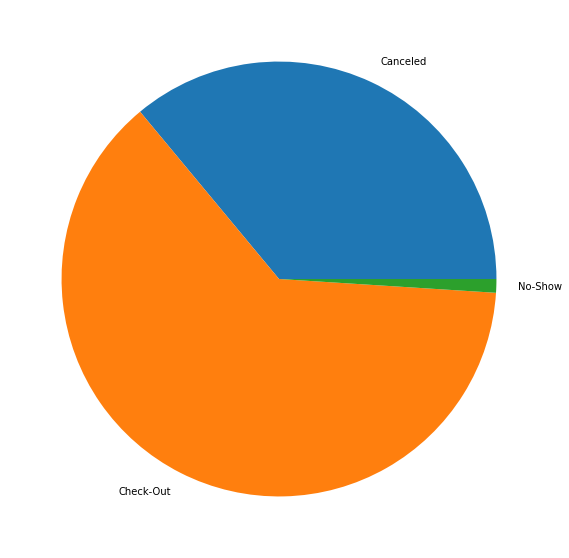

In [59]:
plt.figure(figsize=(10,10))
res_st_data = [sum(clean_data['reservation_status'] == 'Canceled'), sum(clean_data['reservation_status'] == 'Check-Out'), sum(clean_data['reservation_status'] == 'No-Show')]
res_label = ['Canceled', 'Check-Out', 'No-Show']
plt.pie(res_st_data, labels=res_label)
plt.show()

## 'reservation_status' per 'hotel'

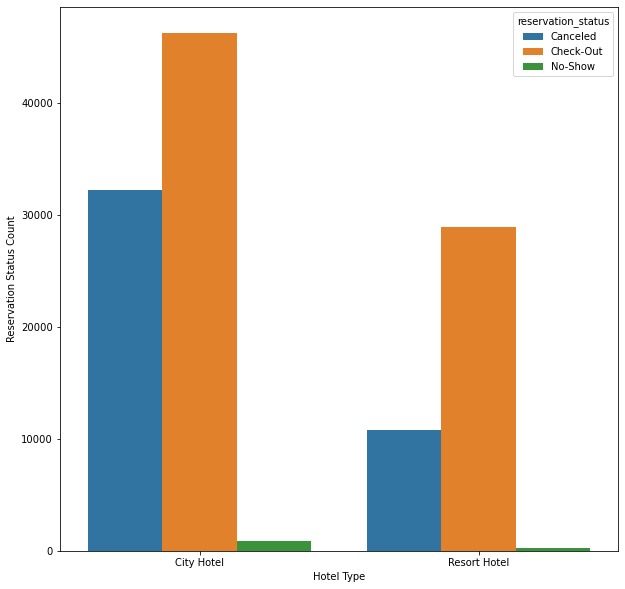

In [60]:
stat_group_data = clean_data.groupby('reservation_status')
hotel_type_data = pd.DataFrame(stat_group_data['hotel'].value_counts())
hotel_type_data.columns = ['count']
hotel_type_data = hotel_type_data.reset_index()

plt.figure(figsize=(10,10))
hotel_type_plot = sns.barplot(y=hotel_type_data['count'], x=hotel_type_data['hotel'], hue=hotel_type_data['reservation_status'])
hotel_type_plot.set(xlabel='Hotel Type', ylabel='Reservation Status Count')

plt.show()

## 'reservation_status' vs 'lead_time'

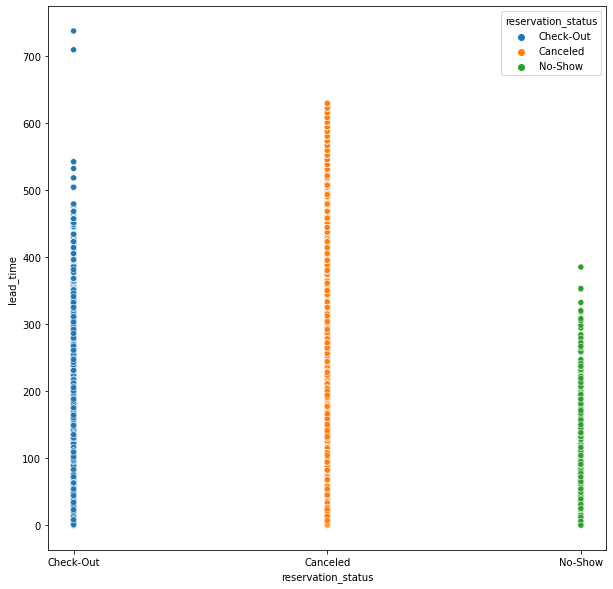

In [61]:
plt.figure(figsize=(10,10))
sns.scatterplot(x= clean_data['reservation_status'], y = clean_data['lead_time'], hue=clean_data['reservation_status'])
plt.show()

## Top 10 'country' per 'reservation_status'

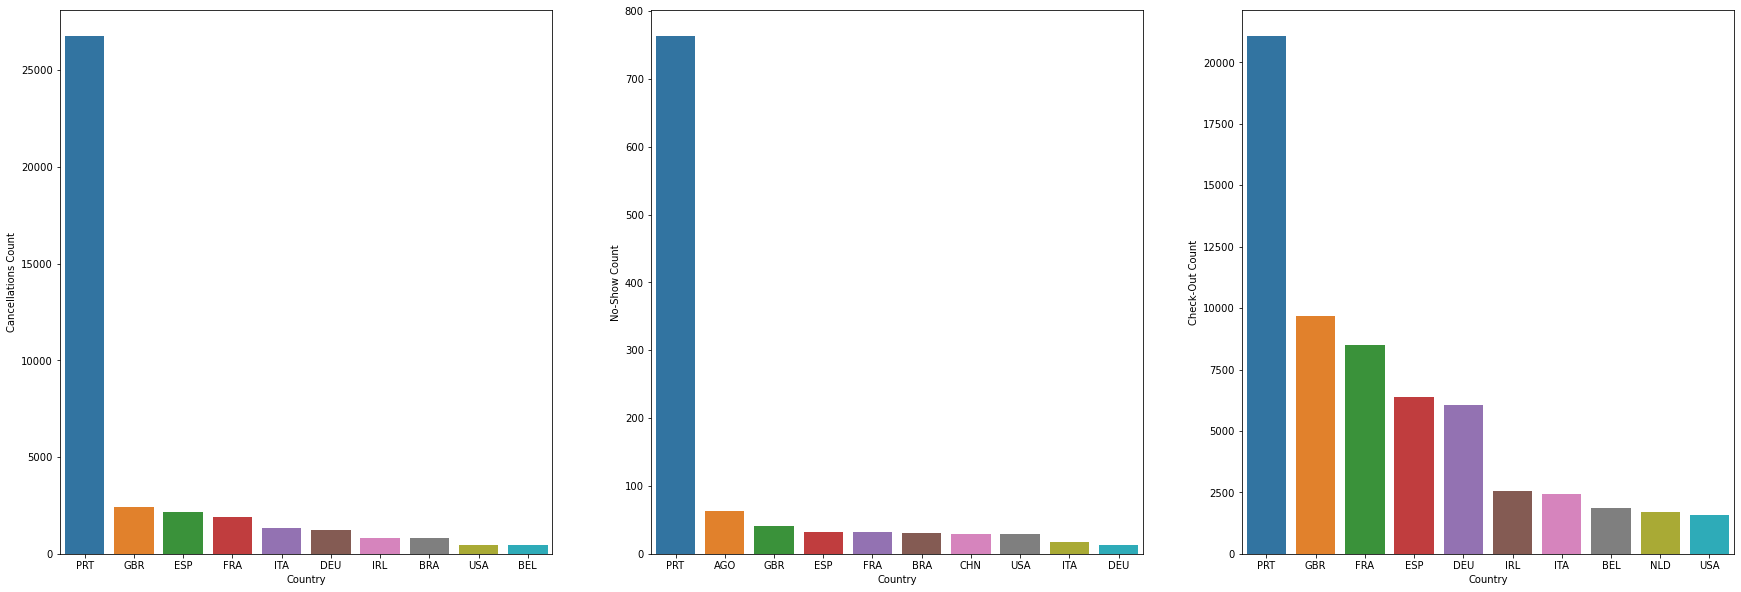

In [62]:
country_data = pd.DataFrame(stat_group_data['country'].value_counts())
country_data.columns = ['count']
country_data = country_data.reset_index()

canceled_country_data = country_data[country_data['reservation_status'] == 'Canceled']
canceled_country_data = canceled_country_data.sort_values(by='count', ascending=False)

noshow_country_data = country_data[country_data['reservation_status'] == 'No-Show']
noshow_country_data = noshow_country_data.sort_values(by='count', ascending=False)

checkout_country_data = country_data[country_data['reservation_status'] == 'Check-Out']
checkout_country_data = checkout_country_data.sort_values(by='count', ascending=False)

fig, axes = plt.subplots(1,3, figsize=(30, 10))

can_plot = sns.barplot(ax=axes[0],y=canceled_country_data['count'].head(10), x=canceled_country_data['country'].head(10))
can_plot.set(xlabel='Country', ylabel='Cancellations Count')

ns_plot = sns.barplot(ax=axes[1],y=noshow_country_data['count'].head(10), x=noshow_country_data['country'].head(10))
ns_plot.set(xlabel='Country', ylabel='No-Show Count')

co_plot = sns.barplot(ax=axes[2],y=checkout_country_data['count'].head(10), x=checkout_country_data['country'].head(10))
co_plot.set(xlabel='Country', ylabel='Check-Out Count')

plt.show()

## 'reservation_status' per 'arrival_date_month'

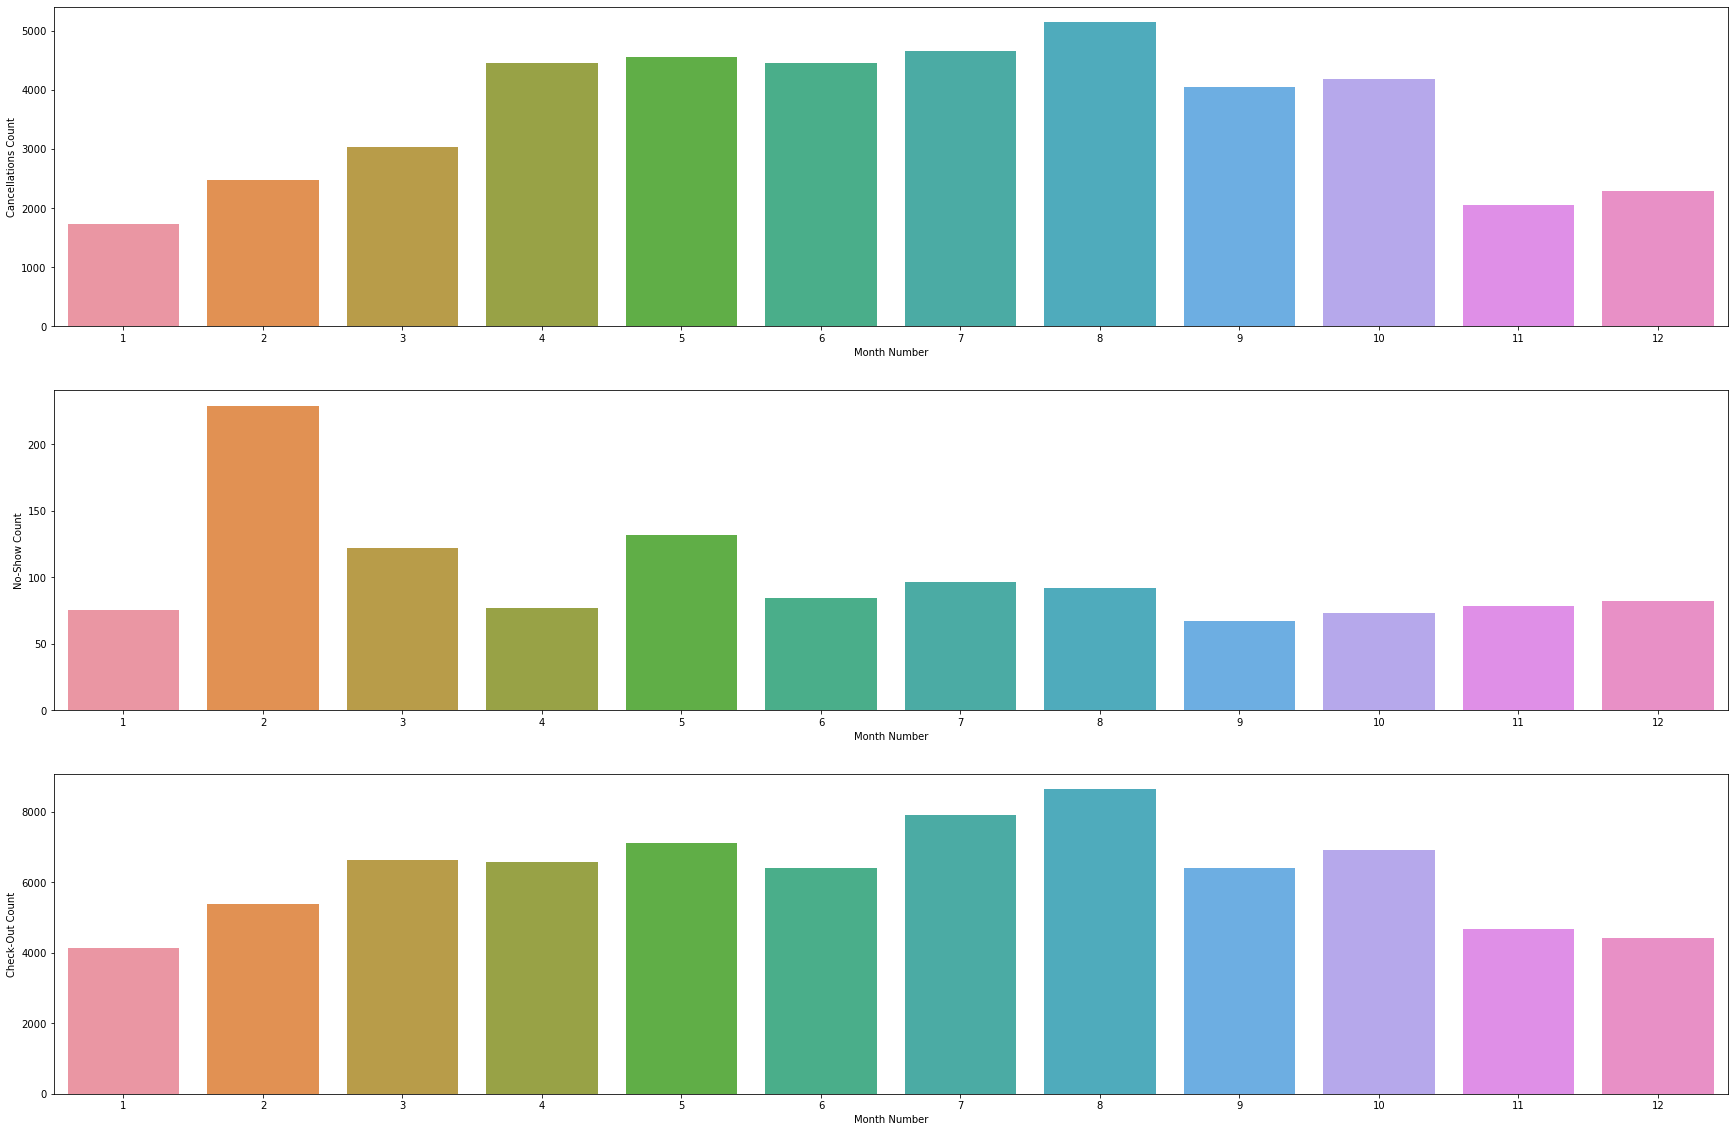

In [63]:
month_data = pd.DataFrame(stat_group_data['arrival_date_month'].value_counts())
month_data.columns = ['count']
month_data = month_data.reset_index()

month_map = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12,}
month_data.arrival_date_month = month_data.arrival_date_month.map(month_map)

canceled_month_data = month_data[month_data['reservation_status'] == 'Canceled']
canceled_month_data = canceled_month_data.sort_values(by='count', ascending=False)

noshow_month_data = month_data[month_data['reservation_status'] == 'No-Show']
noshow_month_data = noshow_month_data.sort_values(by='count', ascending=False)

checkout_month_data = month_data[month_data['reservation_status'] == 'Check-Out']
checkout_month_data = checkout_month_data.sort_values(by='count', ascending=False)

fig, axes = plt.subplots(3,1, figsize=(30, 20))

can_plot = sns.barplot(ax=axes[0],y=canceled_month_data['count'], x=canceled_month_data['arrival_date_month'])
can_plot.set(xlabel='Month Number', ylabel='Cancellations Count')

ns_plot = sns.barplot(ax=axes[1],y=noshow_month_data['count'], x=noshow_month_data['arrival_date_month'])
ns_plot.set(xlabel='Month Number', ylabel='No-Show Count')

co_plot = sns.barplot(ax=axes[2],y=checkout_month_data['count'], x=checkout_month_data['arrival_date_month'])
co_plot.set(xlabel='Month Number', ylabel='Check-Out Count')

plt.show()

## 'reservation_status' per 'customer_type'

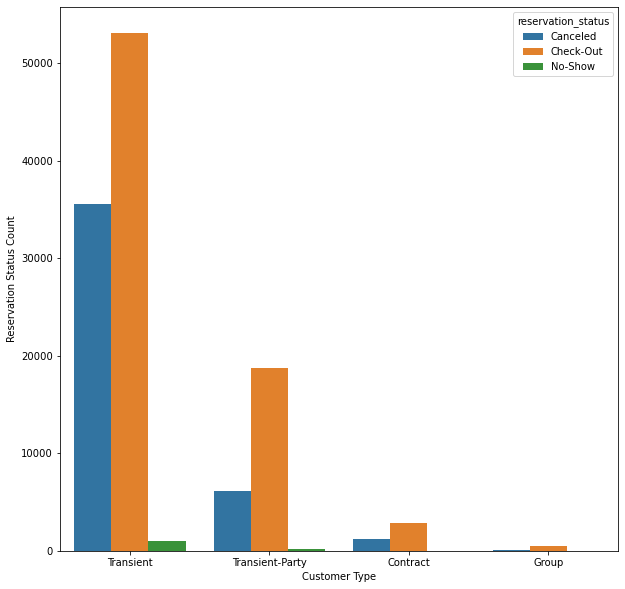

In [64]:
cust_type_data = pd.DataFrame(stat_group_data['customer_type'].value_counts())
cust_type_data.columns = ['count']
cust_type_data = cust_type_data.reset_index()

plt.figure(figsize=(10,10))
cust_type_plot = sns.barplot(y=cust_type_data['count'], x=cust_type_data['customer_type'], hue=cust_type_data['reservation_status'])
cust_type_plot.set(xlabel='Customer Type', ylabel='Reservation Status Count')

plt.show()

## 'reservation_status' per 'market_segment'

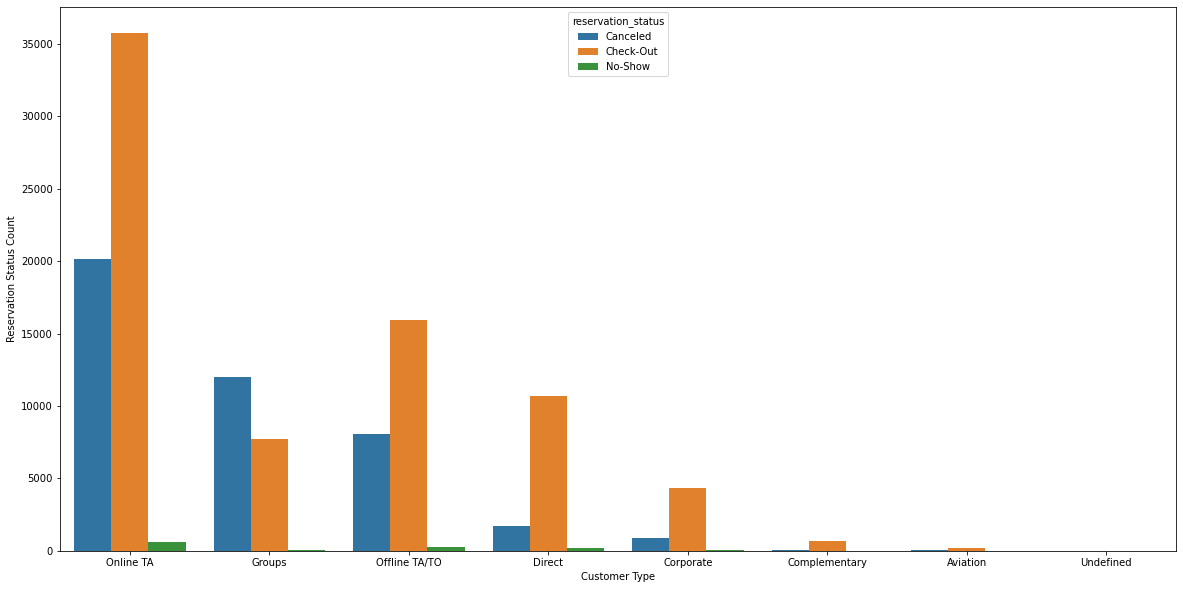

In [65]:
cust_type_data = pd.DataFrame(stat_group_data['market_segment'].value_counts())
cust_type_data.columns = ['count']
cust_type_data = cust_type_data.reset_index()

plt.figure(figsize=(20,10))
market_segment_plot = sns.barplot(y=cust_type_data['count'], x=cust_type_data['market_segment'], hue=cust_type_data['reservation_status'])
market_segment_plot.set(xlabel='Customer Type', ylabel='Reservation Status Count')

plt.show()

## 'reserved_room_obtained' per 'arrival_date_month'

In [66]:
import numpy as np

room_data = clean_data[['reserved_room_type', 'assigned_room_type', 'arrival_date_month']]
ro_list = np.where(clean_data['reserved_room_type'] == clean_data['assigned_room_type'], 'Yes','No')
room_data = room_data.assign(reserved_room_obtained=ro_list)

month_map = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12,}
room_data.arrival_date_month = room_data.arrival_date_month.map(month_map)

room_data = room_data.groupby('arrival_date_month')
room_data = pd.DataFrame(room_data['reserved_room_obtained'].value_counts())
room_data.columns=['count']
room_data = room_data.reset_index()

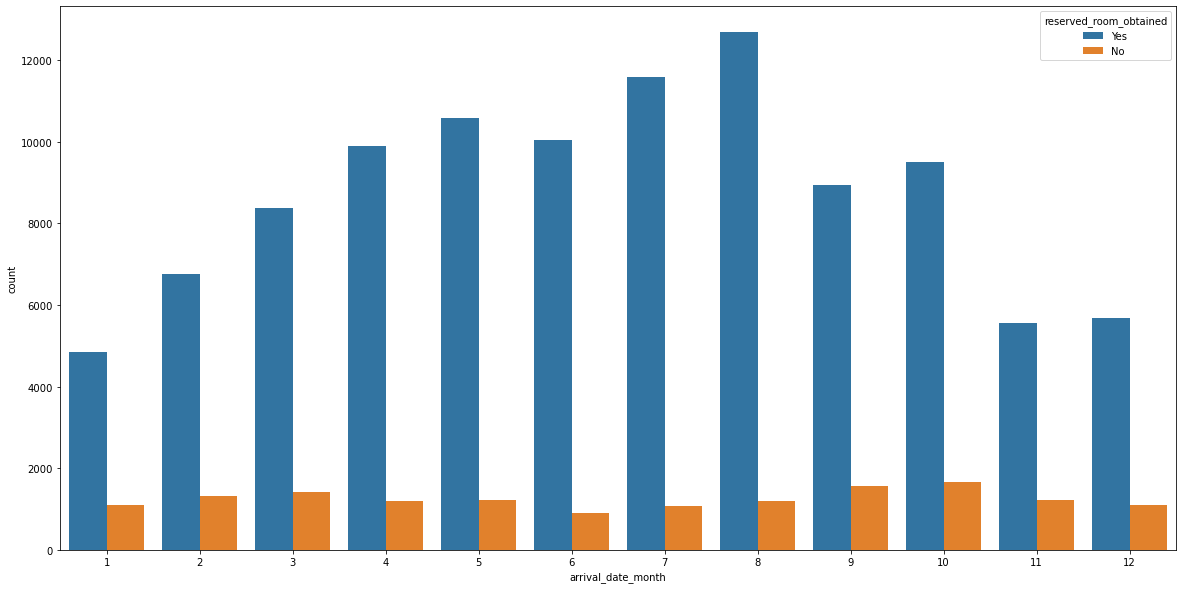

In [67]:
plt.figure(figsize=(20,10))
market_segment_plot = sns.barplot(y=room_data['count'], x=room_data['arrival_date_month'], hue=room_data['reserved_room_obtained'])
market_segment_plot.set(xlabel='arrival_date_month', ylabel='count')

plt.show()

# Classification Model Comparison

## Split data using train_test_split

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_std,Y, test_size = 0.2)

## LogisticRegression()

In [69]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(solver='lbfgs', max_iter=1000)
lgr.fit(X_train, Y_train)
lgr_acc = lgr.score(X_test, Y_test) * 100
print("The Logistic Regression accuracy score is: ", lgr_acc)

The Logistic Regression accuracy score is:  78.25


## KNeighborsClassifier()

In [70]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
knn_acc = knn.score(X_test, Y_test) * 100
print("The KNN accuracy score is: ", knn_acc)

The KNN accuracy score is:  77.25


## GaussianNB()

In [71]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, Y_train)
nb_acc = nb.score(X_test, Y_test) * 100
print("The Naive Bayes accuracy score is: ", nb_acc)

The Naive Bayes accuracy score is:  15.15


## SVC()

In [72]:
from sklearn import svm

svc = svm.SVC()
svc.fit(X_train, Y_train)
svc_acc = svc.score(X_test, Y_test) * 100
print("The SVM accuracy score is: ", svc_acc)

The SVM accuracy score is:  80.75


## DecisionTreeClassifier()

In [73]:
from sklearn import tree

dt = tree.DecisionTreeClassifier()
dt.fit(X_train, Y_train)
dt_acc = dt.score(X_test, Y_test) * 100
print("The Decision Tree accuracy score is: ", dt_acc)

The Decision Tree accuracy score is:  78.05


## GradientBoostingClassifier()

In [74]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)
gb_acc = gb.score(X_test, Y_test) * 100
print("The gradient boosting accuracy score is: ", gb_acc)

The gradient boosting accuracy score is:  85.2


## RandomForestClassifier()

In [75]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
rf_acc = rf.score(X_test, Y_test) * 100
print("The random forest accuracy score is: ", rf_acc)

The random forest accuracy score is:  86.05000000000001


## Model Accuracy Comparison and Visualization

[Text(0.5, 0, 'Learning Model'), Text(0, 0.5, 'Accuracy (%)')]

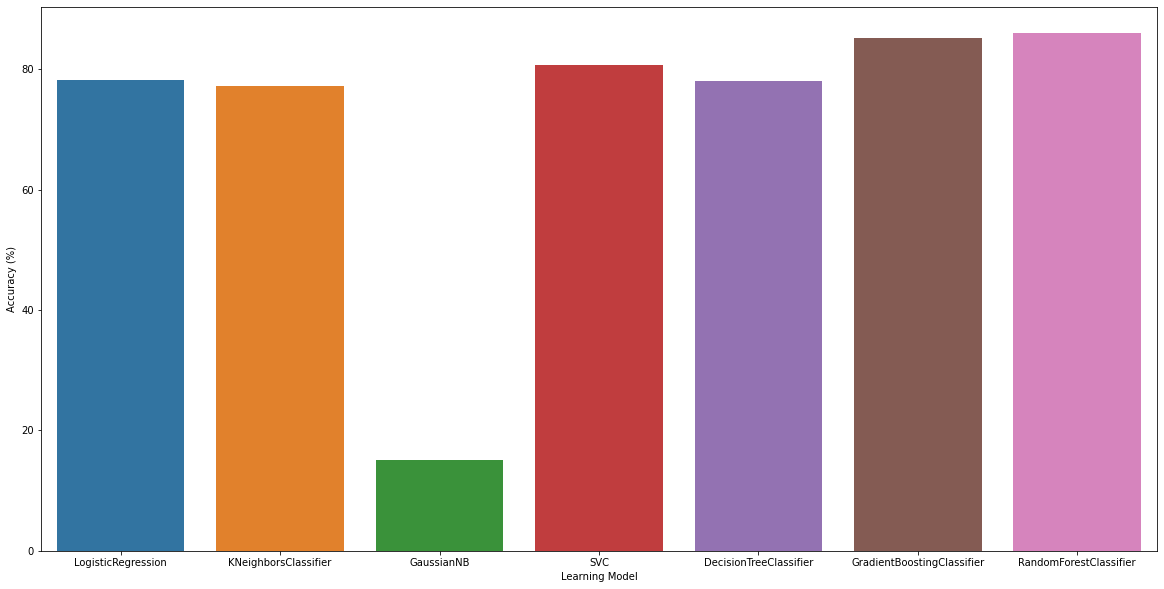

In [76]:
model_list = ['LogisticRegression', 'KNeighborsClassifier', 'GaussianNB', 'SVC', 'DecisionTreeClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier']
model_acc = [lgr_acc, knn_acc, nb_acc, svc_acc, dt_acc, gb_acc, rf_acc]
acc_comp = pd.Series(model_acc, index=model_list)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20,10))
comp_barg = sns.barplot(x = acc_comp.index , y= acc_comp.values)
comp_barg.set(xlabel="Learning Model", ylabel="Accuracy (%)")

# Feature Selection Methods Comparison

## Selection using SelectKBest(chi2)

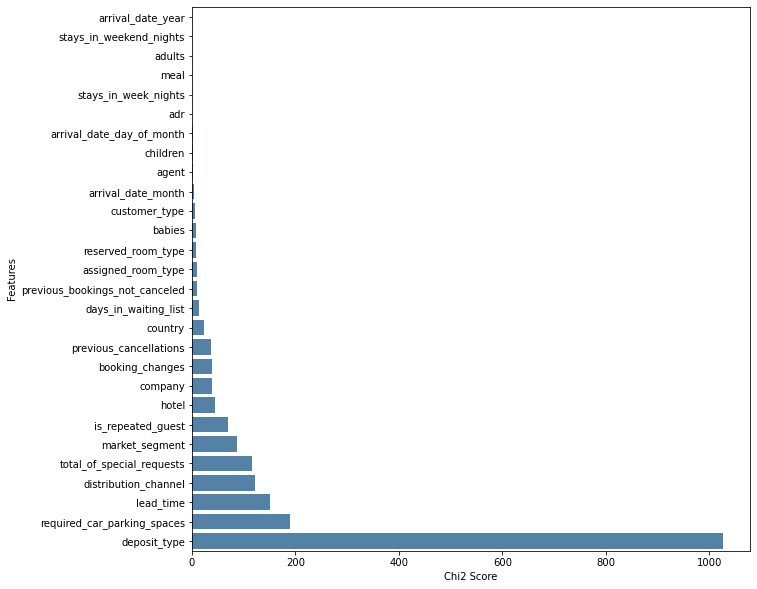

In [77]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

chi2_model = SelectKBest(score_func=chi2, k='all')

chi2_test = chi2_model.fit(X_mm, Y)

chi2_score = pd.Series(chi2_test.scores_, index=X.columns)
chi2_score = chi2_score.sort_values()

plt.figure(figsize=(10,10))

chi2_bar_plot = sns.barplot(x = chi2_score.values, y = chi2_score.index, color='steelblue')
chi2_bar_plot.set(xlabel="Chi2 Score", ylabel="Features")
plt.show()

In [78]:
feat_len = len(chi2_score)
chi2_df = pd.DataFrame()
while (feat_len >= 1):
    X_imp = data[chi2_score.nlargest(feat_len).index]
    
    SS = StandardScaler()
    X_imp_std = SS.fit_transform(X_imp)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_imp_std,Y, test_size = 0.2)
    
    rf = RandomForestClassifier()
    rf.fit(X_train, Y_train)
    
    rf_acc = rf.score(X_test, Y_test) * 100
    rf_ser = pd.Series({'Feature Length': feat_len, 'Accuracy': rf_acc})
    chi2_df = pd.concat([chi2_df, rf_ser.to_frame().T], ignore_index=True)
    
    feat_len = feat_len - 1

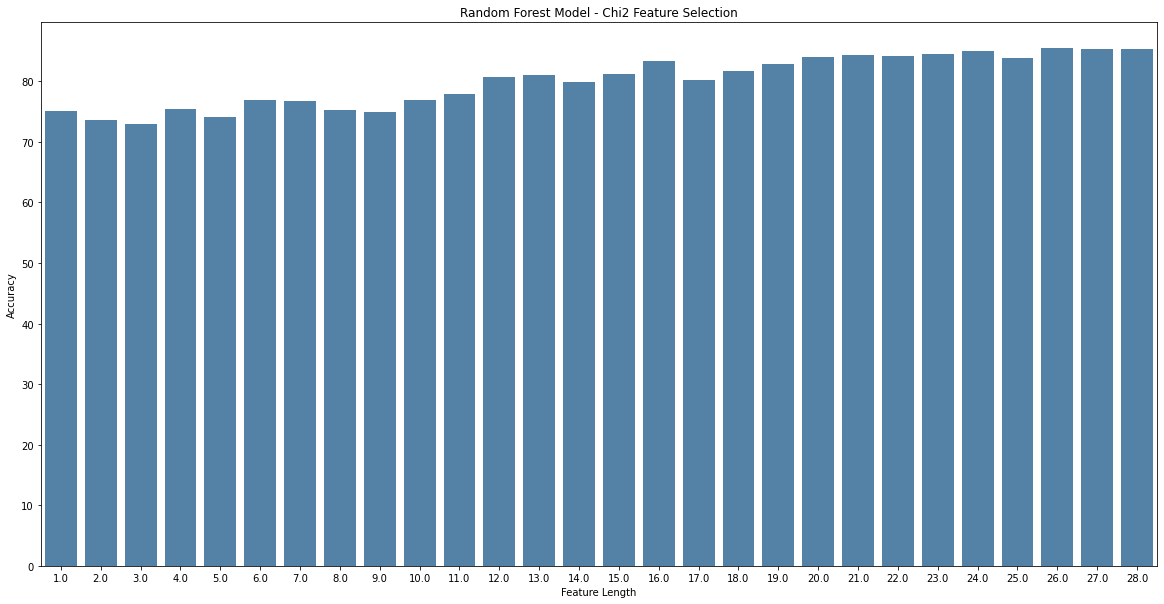

In [79]:
plt.figure(figsize=(20,10)) 
rf_plot = sns.barplot(x=chi2_df['Feature Length'], y=chi2_df['Accuracy'], color='steelblue')
rf_plot.set(title='Random Forest Model - Chi2 Feature Selection')
plt.show()

In [80]:
chi2_df_acc = pd.Series(chi2_df['Accuracy'].describe())
chi2_df_acc

count    28.000000
mean     80.103571
std       4.210545
min      72.900000
25%      76.412500
50%      80.825000
75%      84.012500
max      85.500000
Name: Accuracy, dtype: float64

## Selection Using ExtraTreesClassifier

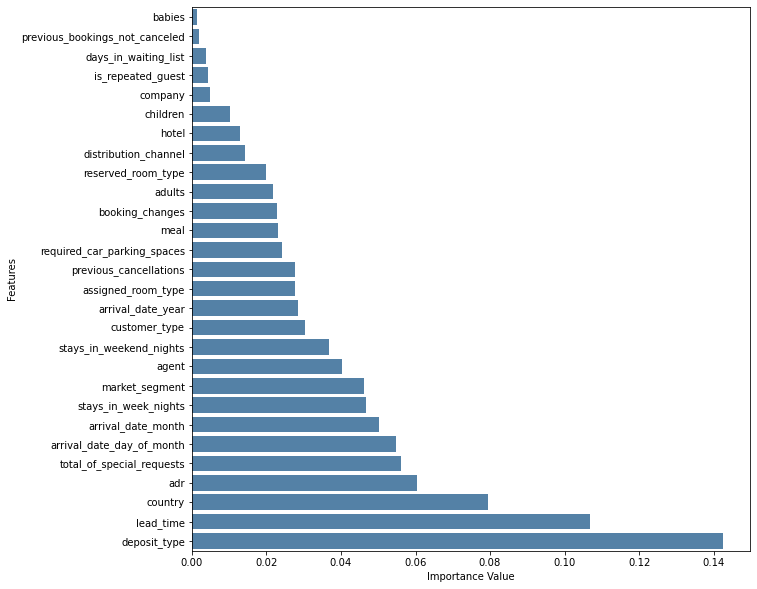

In [81]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_std, Y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values()
plt.figure(figsize=(10,10))
imp_bar_plot = sns.barplot(y = feat_importances.index, x = feat_importances.values, color='steelblue')
imp_bar_plot.set(xlabel="Importance Value", ylabel="Features")
plt.show()

In [82]:
feat_len = len(feat_importances)
ft_imp_df = pd.DataFrame()
while (feat_len >= 1):
    X_imp = data[feat_importances.nlargest(feat_len).index]
    
    SS = StandardScaler()
    X_imp_std = SS.fit_transform(X_imp)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_imp_std,Y, test_size = 0.2)
    
    rf = RandomForestClassifier()
    rf.fit(X_train, Y_train)
    
    rf_acc = rf.score(X_test, Y_test) * 100
    rf_ser = pd.Series({'Feature Length': feat_len, 'Accuracy': rf_acc})
    ft_imp_df = pd.concat([ft_imp_df, rf_ser.to_frame().T], ignore_index=True)
    
    feat_len = feat_len - 1

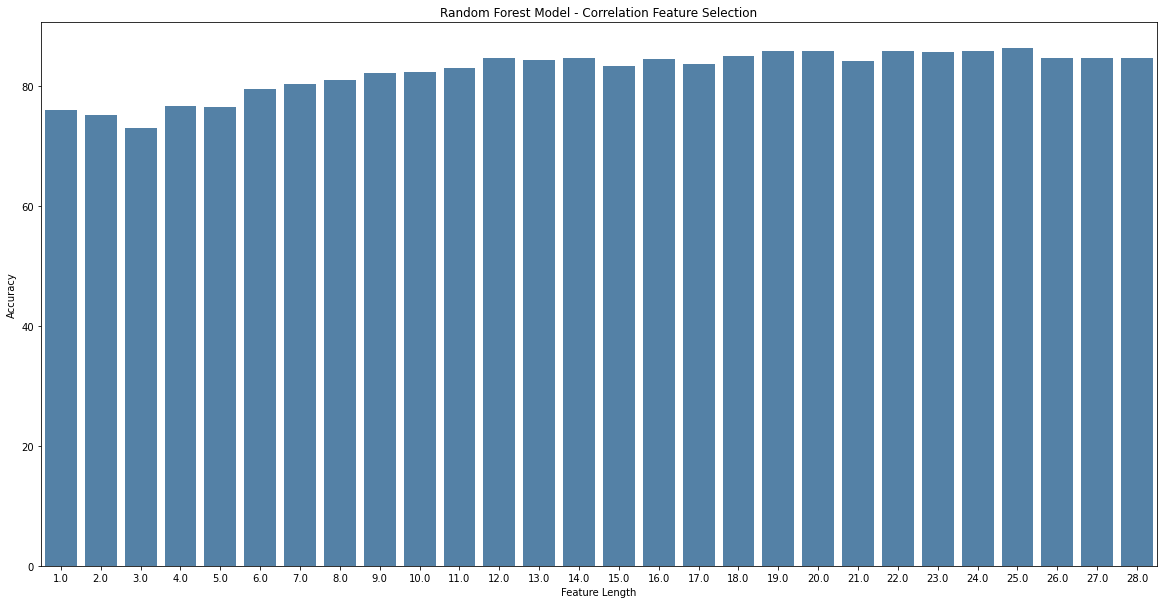

In [83]:
plt.figure(figsize=(20,10)) 
rf_plot = sns.barplot(x=ft_imp_df['Feature Length'], y=ft_imp_df['Accuracy'], color='steelblue')
rf_plot.set(title='Random Forest Model - Correlation Feature Selection')
plt.show()

In [84]:
ft_imp_df_acc = pd.Series(ft_imp_df['Accuracy'].describe())
ft_imp_df_acc

count    28.000000
mean     82.521429
std       3.762201
min      73.050000
25%      80.912500
50%      84.300000
75%      84.837500
max      86.350000
Name: Accuracy, dtype: float64

## Selection Using Correlation Value

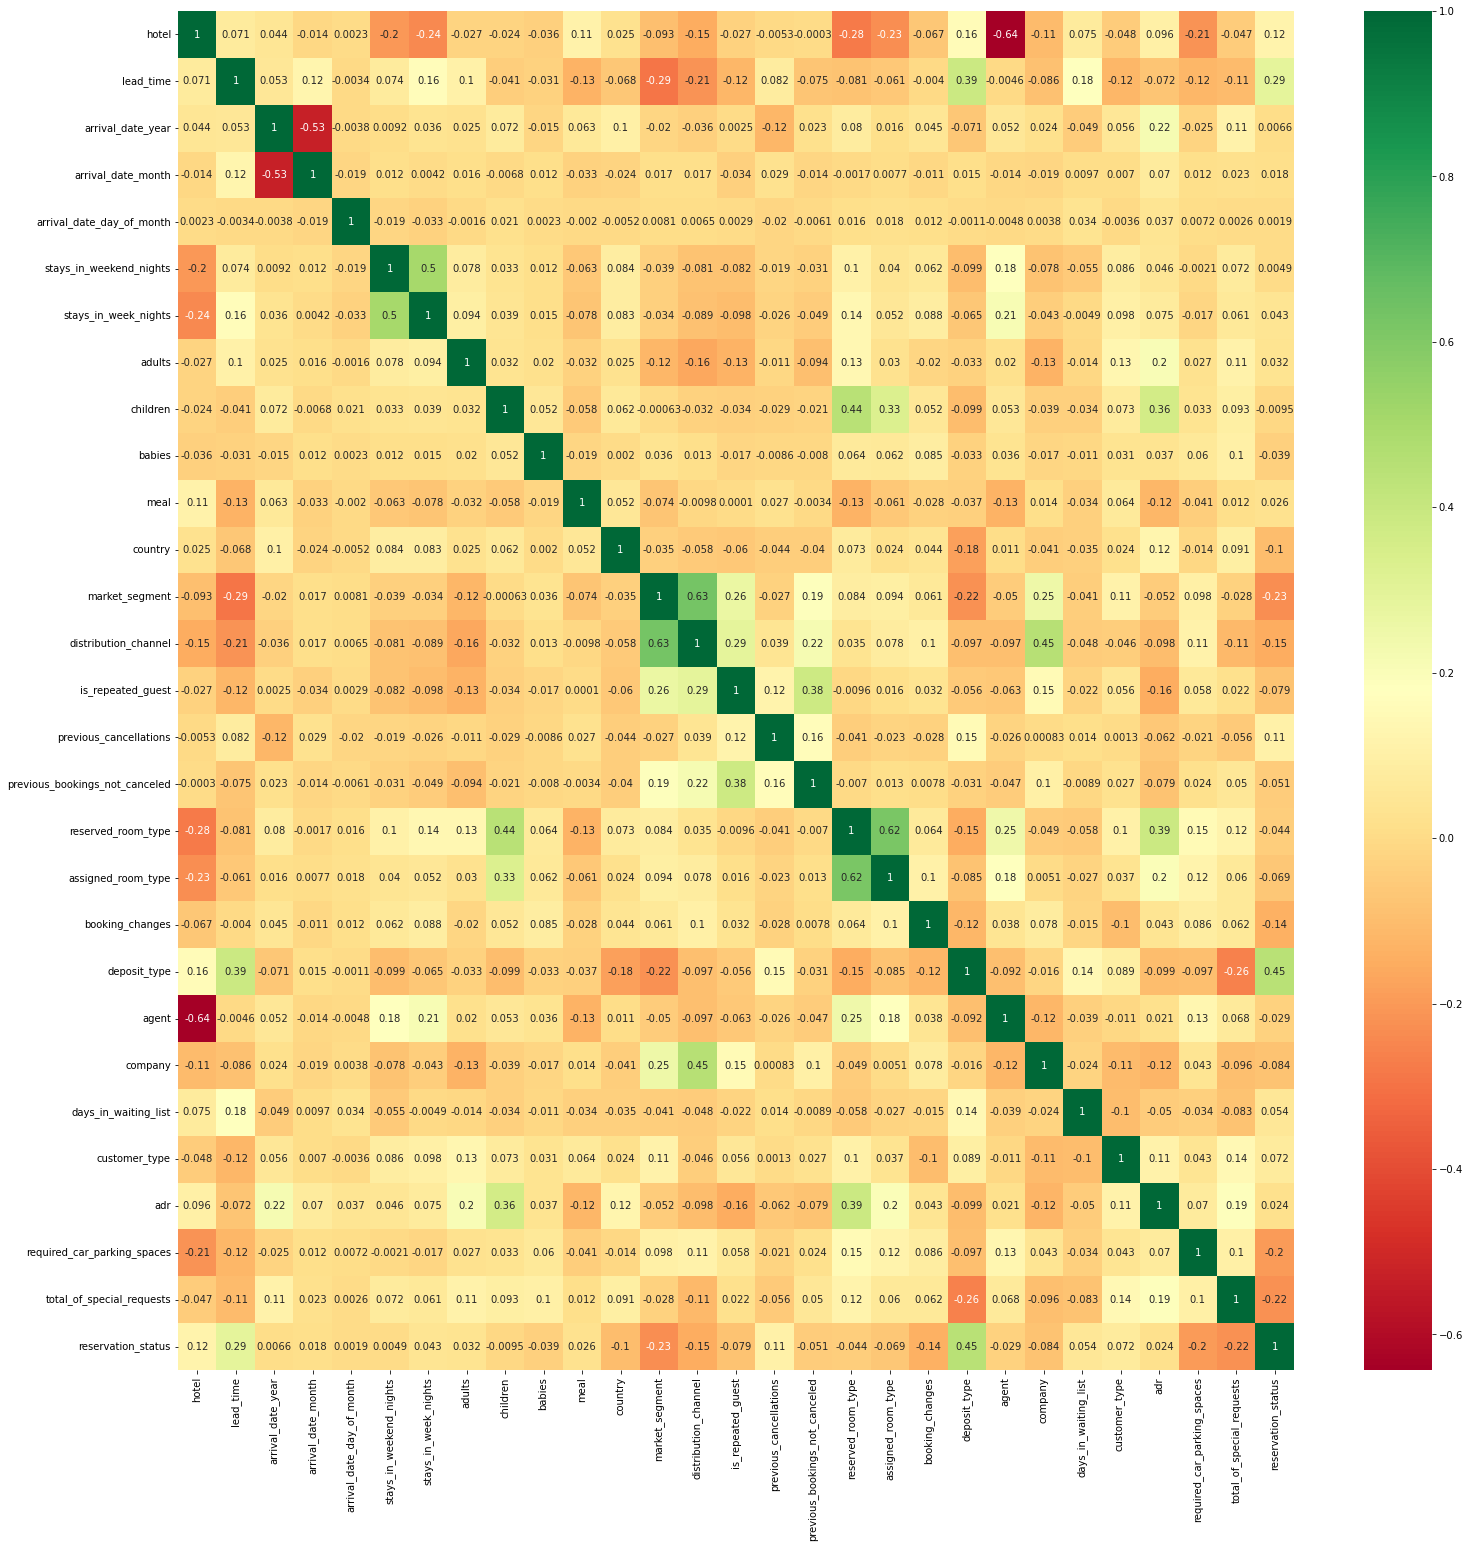

In [85]:
corr_mtx = data.corr()

plt.figure(figsize=(25,25))
hmap = sns.heatmap(corr_mtx, annot=True, cmap="RdYlGn")
plt.show()

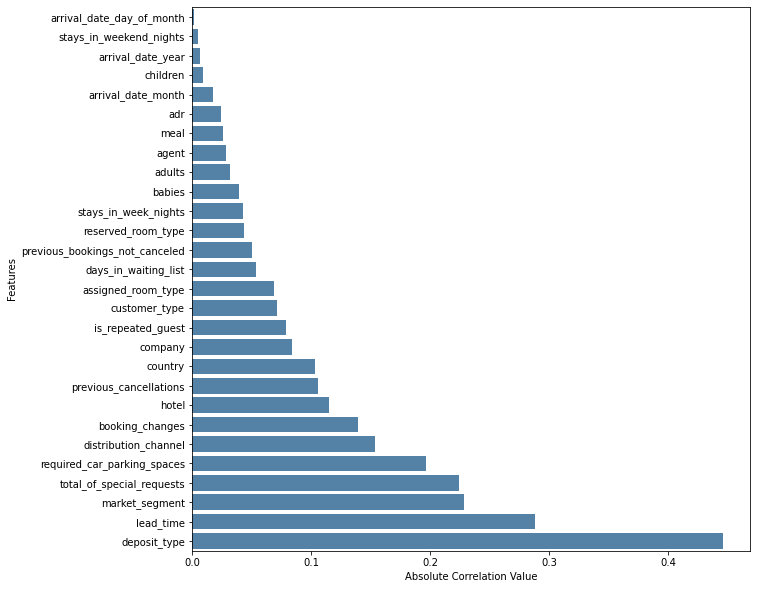

In [86]:
target_corr = corr_mtx['reservation_status'].drop(['reservation_status'], axis=0)
for val in range(len(target_corr)):
    target_corr[val] = abs(target_corr[val])
plt.figure(figsize=(10,10))
target_corr = target_corr.sort_values()
corr_bar_plot = sns.barplot(y = target_corr.index, x = target_corr.values, color='steelblue')
corr_bar_plot.set(xlabel="Absolute Correlation Value", ylabel="Features")
plt.show()

In [87]:
feat_len = len(target_corr)
corr_df = pd.DataFrame()

while (feat_len >= 1):
    X_imp = data[target_corr.nlargest(feat_len).index]
    
    SS = StandardScaler()
    X_imp_std = SS.fit_transform(X_imp)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_imp_std,Y, test_size = 0.2)
    
    rf = RandomForestClassifier()
    rf.fit(X_train, Y_train)
    
    rf_acc = rf.score(X_test, Y_test) * 100
    rf_ser = pd.Series({'Feature Length': feat_len, 'Accuracy': rf_acc})
    corr_df = pd.concat([corr_df, rf_ser.to_frame().T], ignore_index=True)
    
    feat_len = feat_len - 1

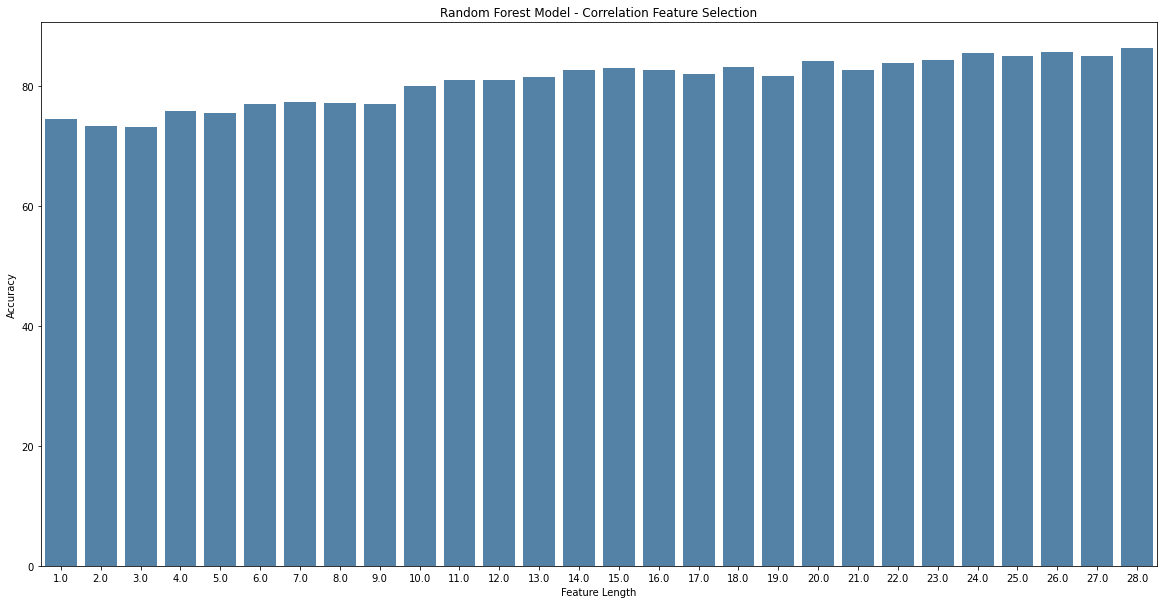

In [88]:
plt.figure(figsize=(20,10))
rf_plot = sns.barplot(x=corr_df['Feature Length'], y=corr_df['Accuracy'], color='steelblue')
rf_plot.set(title='Random Forest Model - Correlation Feature Selection')
plt.show()

In [89]:
corr_df_acc = pd.Series(corr_df['Accuracy'].describe())
corr_df_acc

count    28.000000
mean     80.873214
std       4.006903
min      73.150000
25%      77.212500
50%      81.975000
75%      83.950000
max      86.400000
Name: Accuracy, dtype: float64

## Accuracy Comparison and Visualization

In [90]:
acc_comp_df = pd.DataFrame()
acc_comp_df = pd.concat([chi2_df_acc.to_frame().T, ft_imp_df_acc.to_frame().T, corr_df_acc.to_frame().T])
acc_comp_df.index = ['Chi2 Score', 'Feature Importance', 'Correlation Score']
acc_comp_df

,count,mean,std,min,25%,50%,75%,max
Chi2 Score,28.0,80.103571,4.210545,72.90,76.4125,80.825,84.0125,85.50
Feature Importance,28.0,82.521429,3.762201,73.05,80.9125,84.300,84.8375,86.35
Correlation Score,28.0,80.873214,4.006903,73.15,77.2125,81.975,83.9500,86.40


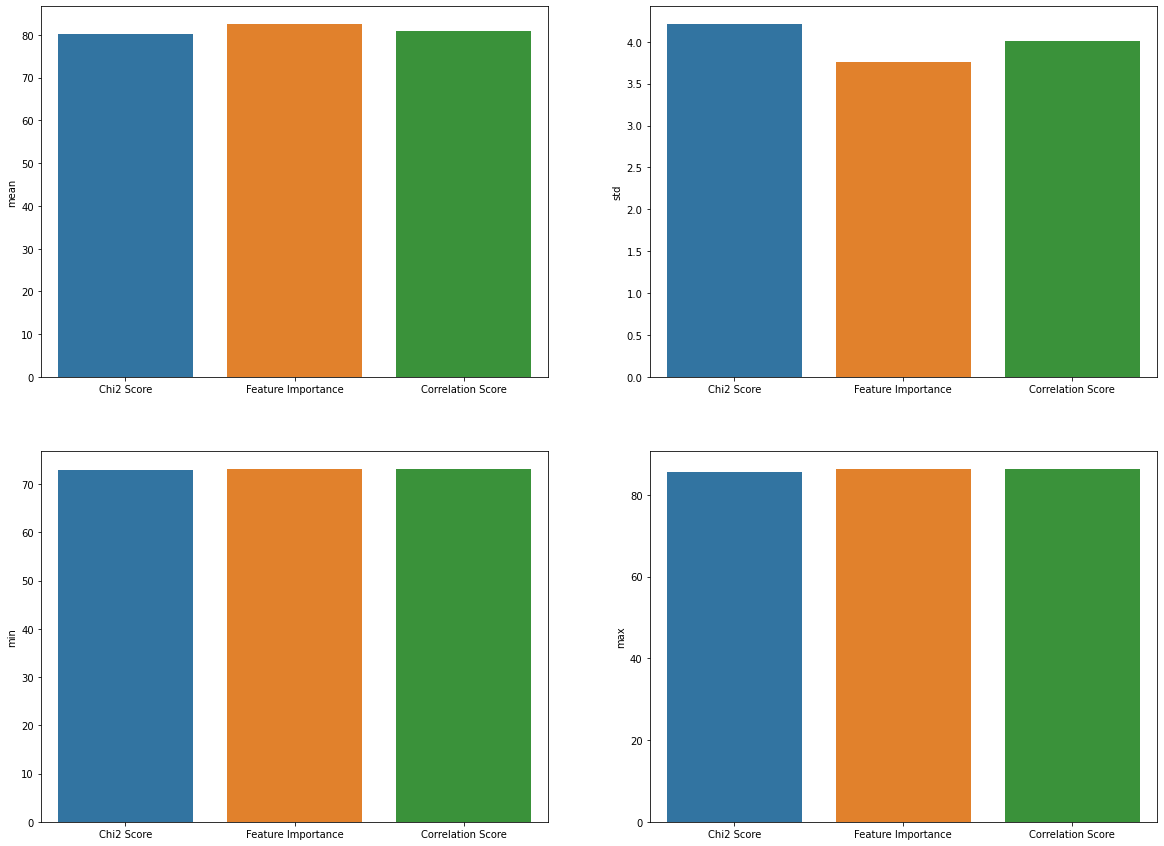

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.barplot(ax=axes[0, 0], x=acc_comp_df.index, y=acc_comp_df['mean'])
sns.barplot(ax=axes[0, 1], x=acc_comp_df.index, y=acc_comp_df['std'])
sns.barplot(ax=axes[1, 0], x=acc_comp_df.index, y=acc_comp_df['min'])
sns.barplot(ax=axes[1, 1], x=acc_comp_df.index, y=acc_comp_df['max'])
plt.show()